# Imports

Standard Imports

In [2]:
import pickle
import pandas as pd
import numpy as np
import re
import warnings
from pprint import pprint

LDA Imports

In [3]:
import gensim
import spacy
import nltk; # nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

SKLEARN - Supervised Training Imports

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score

Visualisation Imports

In [5]:
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
import matplotlib.pyplot as plt

Hypothesis Testing Imports

In [6]:
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

# Gather Data & Do Pre-Analysis

Import Training Data (from pickle file in this instance)

In [319]:
# Import emails
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# Filter on 5 known topics for brevity
data = df[(df.target==1) | (df.target==6) | (df.target==11) | (df.target==16)]
data_train = data.reset_index()
data_train['content_len'] = data_train['content'].apply(lambda x: len(x.split()))




In [221]:
topics = []
for i in data_train['target'].unique():
    target_name = data_train[data_train.target == i].target_names.unique()[0]
    topics.append([i, target_name])

In [222]:
topics

[[1, 'comp.graphics'],
 [16, 'talk.politics.guns'],
 [6, 'misc.forsale'],
 [11, 'sci.crypt']]

Email length vs topic No

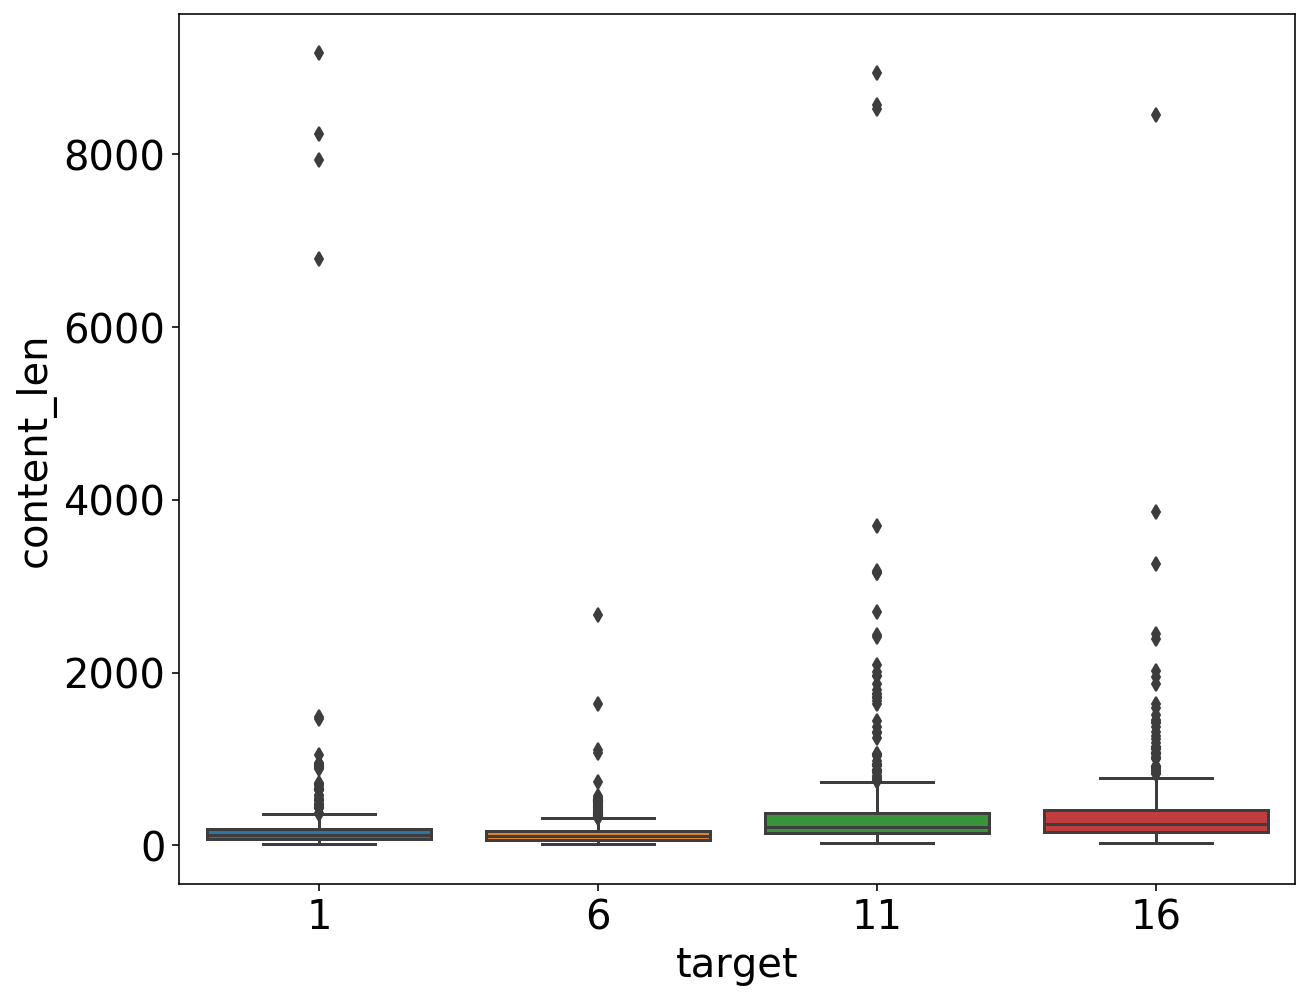

In [197]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size' : 20})
sns.boxplot(x = 'target', y = 'content_len', data = data_train)

Number of emails vs topic

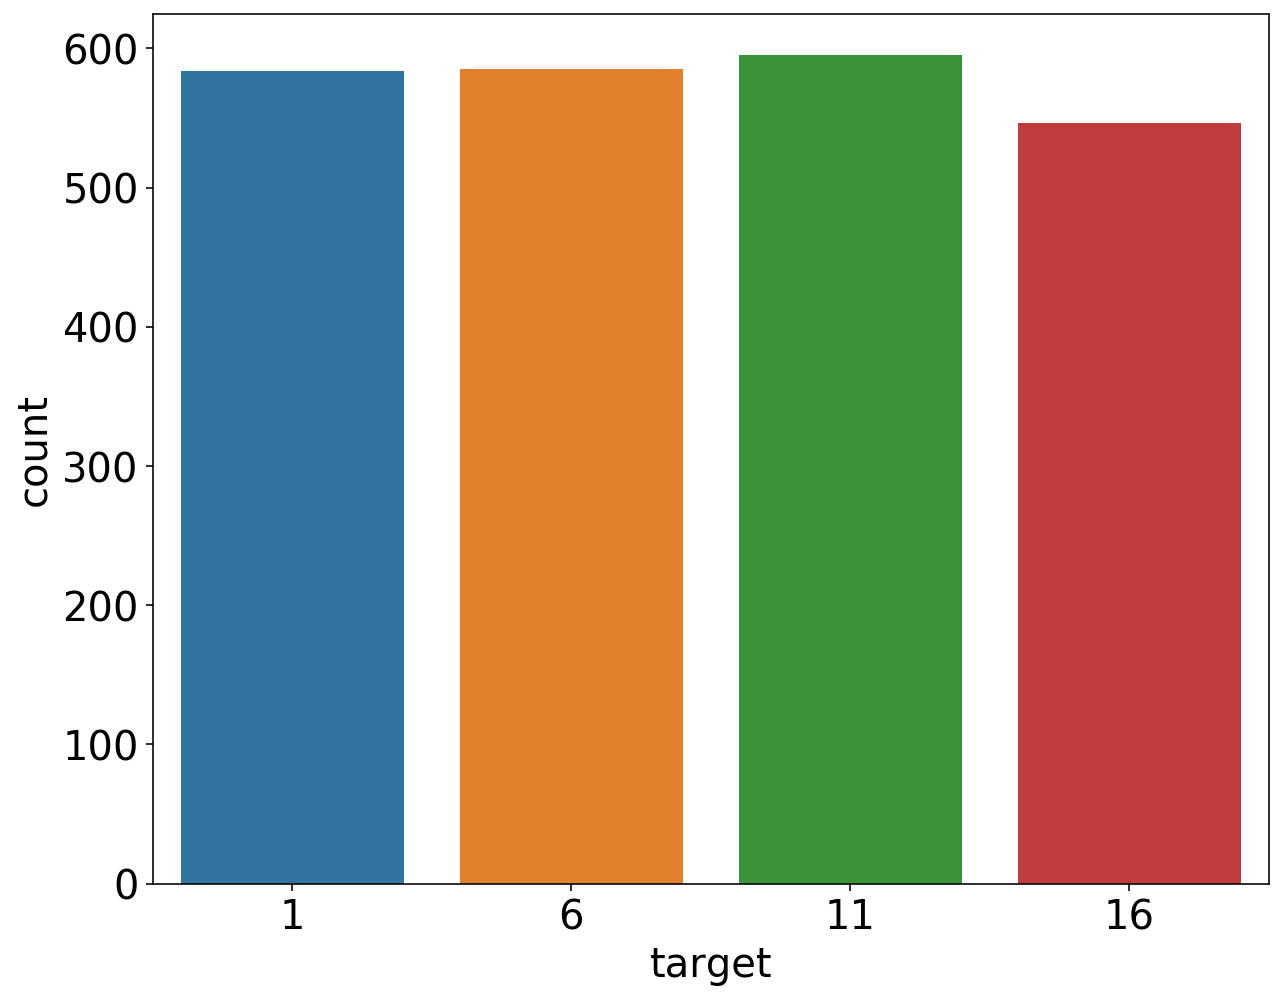

In [198]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot('target', data = data_train)

Gensim LDA standard pre-process

In [199]:
# Edit these dependent upon your pre analysis of the data
stop_extra = ['from', 'subject', 're', 'edu', 'use']

# Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(stop_extra)

# Spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

# Regex strip all documents
def RegStrip(documents, reg, rep):
    return [re.sub(reg, rep, document) for document in documents]

# Tokenise and remove stopwords
def DocToWords(documents):
    output = []
    for doc in documents:
        x = simple_preprocess(str(doc), deacc=True)
        output.append([word for word in x if word not in stop_words])  
    return output

# Generate bi/trigram models 
def BigramModel(tokens, bi_min=15):
    
    bigram = gensim.models.Phrases(tokens, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    return bigram_mod

# Lemmatise documents
def Lemmatise(documents, allowed_posttags=['NOUN', 'ADV']):
    docs_out = []
    for doc in documents:
        doc_whole = nlp(" ".join(doc))
        docs_out.append([token.lemma_ for token in doc_whole if token.pos_ in allowed_posttags])
    return docs_out

# Generate a full corpus, with bi/trigrams, id2word mapping and document BOW vectors using the above standard functions
def GetCorpus(df):
    df['content'] = RegStrip(df.content, '\S*@\S*\s?', '')
    df['content'] = RegStrip(df.content, '\s+', ' ')
    words = DocToWords(df.content)
    bigram = BigramModel(words)
    bigram = [bigram[text] for text in words]
    lemma = Lemmatise(bigram, allowed_posttags=['NOUN', 'ADV'])
    id2word = gensim.corpora.Dictionary(lemma)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in lemma]
    
    return corpus, id2word, lemma
    
    

In [200]:
# Using small slice of total data for brevity
corpus_train, id2word_train, tokens_train = GetCorpus(data_train)

LDA training function

In [208]:
def TrainLda(corpus, id2word, k, alpha='symmetric', eta=None, chunk=100, passes=10):
    lda = gensim.models.ldamulticore.LdaMulticore(
                                            corpus=corpus,
                                            num_topics=k,
                                            id2word=id2word,
                                            chunksize=chunk,
                                            passes=passes,
                                            alpha=alpha,
                                            eta=eta,
                                            workers=3,
                                            eval_every=1,
                                            per_word_topics=True)
    return lda

def GetCoherence(lda, bow, id2word):
    coherence_model_lda = CoherenceModel(model=lda, texts=bow, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # I know there are only 4 topics, so use k = 4
    lda_train_model = TrainLda(corpus_train, id2word_train, 4)
    lda_train_model_a = TrainLda(corpus_train, id2word_train, 4, alpha='asymmetric')
    

cv = GetCoherence(lda_train_model, tokens_train, id2word_train)
cv_a = GetCoherence(lda_train_model_a, tokens_train, id2word_train)

print('Symmetric Model')
print(cv)
pprint(lda_train_model.show_topics(formatted=False))
print('\nAsymmetric Model')
print(cv_a)
pprint(lda_train_model_a.show_topics(formatted=False))

Symmetric Model
0.5274743567083462
[(0,
  [('government', 0.022611318),
   ('system', 0.021407641),
   ('encryption', 0.020968065),
   ('privacy', 0.015165757),
   ('chip', 0.015153713),
   ('key', 0.013943259),
   ('clipper', 0.012563946),
   ('phone', 0.01184816),
   ('device', 0.010790856),
   ('information', 0.010359325)]),
 (1,
  [('bit', 0.021165734),
   ('key', 0.016884627),
   ('message', 0.015094665),
   ('people', 0.014693457),
   ('part', 0.012005967),
   ('group', 0.011374294),
   ('time', 0.011286134),
   ('chip', 0.009574097),
   ('militia', 0.009542298),
   ('even', 0.008423)]),
 (2,
  [('gun', 0.030899199),
   ('people', 0.020705508),
   ('weapon', 0.010718011),
   ('time', 0.010431602),
   ('firearm', 0.01009066),
   ('law', 0.009986719),
   ('thing', 0.009840073),
   ('government', 0.009595009),
   ('even', 0.007679238),
   ('point', 0.0074413065)]),
 (3,
  [('file', 0.021865033),
   ('image', 0.019840145),
   ('program', 0.01407922),
   ('software', 0.013619147),
   

# MANUAL INPUT REQUIRED: Match LDA Topics to Known Topics

In [242]:
import copy
pprint(topics)
topics_matched_s = []
topics_matched_s = copy.deepcopy(topics)
topics_matched_a = []
topics_matched_a = copy.deepcopy(topics)

x = lda_train_model.show_topics(formatted=False)
topics_matched_s[0].extend([x[0][0], x[0][1]])
topics_matched_s[1].extend([x[2][0], x[2][1]])
topics_matched_s[2].extend([x[3][0], x[3][1]])
topics_matched_s[3].extend([x[1][0], x[1][1]])

y = lda_train_model_a.show_topics(formatted=False)
topics_matched_a[0].extend([y[0][0], y[0][1]])
topics_matched_a[1].extend([y[1][0], y[1][1]])
topics_matched_a[2].extend([y[3][0], y[3][1]])
topics_matched_a[3].extend([y[2][0], y[2][1]])


pprint(topics_matched_s)
pprint(topics_matched_a)

topics_matched_s_dict = {}
for x in topics_matched_s:
    topics_matched_s_dict[x[2]] = x[0]
print('\nLDATopic-Topic Matching\nSymmetric:')   
pprint(topics_matched_s_dict)

topics_matched_a_dict = {}
for x in topics_matched_a:
    topics_matched_a_dict[x[2]] = x[0]
print('\nAsymmetric')
pprint(topics_matched_a_dict)

[[1, 'comp.graphics'],
 [16, 'talk.politics.guns'],
 [6, 'misc.forsale'],
 [11, 'sci.crypt']]
[[1,
  'comp.graphics',
  0,
  [('government', 0.022611318),
   ('system', 0.021407641),
   ('encryption', 0.020968065),
   ('privacy', 0.015165757),
   ('chip', 0.015153713),
   ('key', 0.013943259),
   ('clipper', 0.012563946),
   ('phone', 0.01184816),
   ('device', 0.010790856),
   ('information', 0.010359325)]],
 [16,
  'talk.politics.guns',
  2,
  [('gun', 0.030899199),
   ('people', 0.020705508),
   ('weapon', 0.010718011),
   ('time', 0.010431602),
   ('firearm', 0.01009066),
   ('law', 0.009986719),
   ('thing', 0.009840073),
   ('government', 0.009595009),
   ('even', 0.007679238),
   ('point', 0.0074413065)]],
 [6,
  'misc.forsale',
  3,
  [('file', 0.021865033),
   ('image', 0.019840145),
   ('program', 0.01407922),
   ('software', 0.013619147),
   ('system', 0.011925892),
   ('also', 0.011820045),
   ('sale', 0.011816021),
   ('package', 0.010079881),
   ('color', 0.009245491),
  

In [283]:
def documentTopic(ldamodel, corpus, texts):
    # Output is a df
    document_topic_df = pd.DataFrame()
    
    # Get dominant topic for each doc
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True) # this sorts by probability value, so the first element has the largest p 
        for j, (topic_num, topic_val) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num) # word/probability bin for given topic
                topic_keywords = ','.join([word for word, val in wp]) # aggregate words into list
                document_topic_df = document_topic_df.append(pd.Series([int(topic_num), round(topic_val,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topic_df.columns=['Topic', 'Probability', 'Keywords']
    
    # Add original text at the end
    document_topic_df = pd.concat([texts, document_topic_df], axis=1)
    return document_topic_df

Concatenate the results from the two models and use the dictionaries to convert the LDA topic keys to the same values as the target key

In [320]:
data_train = documentTopic(lda_train_model, corpus_train, data_train)
data_train = data_train.rename(columns={"Topic": "Topic-LDA_S", "Probability": "Probability-LDA_S", "Keywords": "Keywords-LDA_S"})
data_train = documentTopic(lda_train_model_a, corpus_train, data_train)
data_train = data_train.rename(columns={"Topic": "Topic-LDA_A", "Probability": "Probability-LDA_A", "Keywords": "Keywords-LDA_A"})

for i, row in data_train.iterrows():
    val_s = topics_matched_s_dict[int(row['Topic-LDA_S'])]
    data_train.at[i, 'Topic-LDA_S'] = val_s
    
    val_a = topics_matched_a_dict[int(row['Topic-LDA_A'])]
    data_train.at[i, 'Topic-LDA_A'] = val_a
    
data_train.head(10)

,index,content,target,target_names,content_len,Topic-LDA_S,Probability-LDA_S,Keywords-LDA_S,Topic-LDA_A,Probability-LDA_A,Keywords-LDA_A
0,3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,113,1.0,0.6194,"government,system,encryption,privacy,chip,key,...",11.0,0.5360,"key,encryption,system,chip,government,message,..."
1,5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns,398,16.0,0.8144,"gun,people,weapon,time,firearm,law,thing,gover...",16.0,0.9853,"gun,people,time,government,thing,weapon,law,fi..."
2,14,From: jllee@acsu.buffalo.edu (Johnny L Lee)\nS...,6,misc.forsale,219,6.0,0.9734,"file,image,program,software,system,also,sale,p...",1.0,0.9789,"file,image,program,also,color,point,graphic,so..."
3,16,From: ab@nova.cc.purdue.edu (Allen B)\nSubject...,1,comp.graphics,324,6.0,0.7953,"file,image,program,software,system,also,sale,p...",1.0,0.6962,"file,image,program,also,color,point,graphic,so..."
4,22,From: rpwhite@cs.nps.navy.mil (rpwhite)\nSubje...,6,misc.forsale,288,6.0,0.8507,"file,image,program,software,system,also,sale,p...",6.0,0.9807,"sale,system,price,software,cd,disk,game,machin..."
5,25,From: kph2q@onyx.cs.Virginia.EDU (Kenneth Hinc...,1,comp.graphics,142,6.0,0.7305,"file,image,program,software,system,also,sale,p...",6.0,0.6123,"sale,system,price,software,cd,disk,game,machin..."
6,30,From: mrh@iastate.edu (Michael R Hartman)\nSub...,6,misc.forsale,300,11.0,0.7167,"bit,key,message,people,part,group,time,chip,mi...",1.0,0.6974,"file,image,program,also,color,point,graphic,so..."
7,37,From: ebrandt@jarthur.claremont.edu (Eli Brand...,11,sci.crypt,489,1.0,0.5383,"government,system,encryption,privacy,chip,key,...",11.0,0.6159,"key,encryption,system,chip,government,message,..."
8,39,From: bressler@iftccu.ca.boeing.com (Rick Bres...,16,talk.politics.guns,866,16.0,0.9041,"gun,people,weapon,time,firearm,law,thing,gover...",16.0,0.9336,"gun,people,time,government,thing,weapon,law,fi..."
9,55,From: cme@ellisun.sw.stratus.com (Carl Ellison...,11,sci.crypt,177,11.0,0.6044,"bit,key,message,people,part,group,time,chip,mi...",11.0,0.6025,"key,encryption,system,chip,government,message,..."


# Testing Symmetric vs Asymmetric

We now have the known topics values ('target'), the LDA-Symmetric ('Topic-LDA_S') and LDA-Asymmetric ('Topic-LDA_A') predictions. Therefore, we can peform a McNemar chi-sqaured/P test to determine whether they are statistically different

In [321]:
y_true = data_train['target']
y_m1 = data_train['Topic-LDA_S']
y_m2 = data_train['Topic-LDA_A']

tb = mcnemar_table(y_target=y_true, y_model1=y_m1, y_model2=y_m2)
print(tb)
chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

[[894 837]
 [290 289]]
chi-squared: 264.5217391304348
p-value: 1.7738503487126205e-59


The p-value is significantly small, therefore we can reject the hypothesis that both the models are equal.

We can also see from the McNemar that M2 got 837 topics correct that M1 got wrong (0,1).
Whereas, M1 only got 290 topics correct that M2 got wrong (1,0).

This makes M2 significantly better at identifying correct topics and we can thus determine that:

# The Asymmetric LDA model outperforms the Symmetric LDA model in this instance.